In [53]:
import itertools
from timeit import default_timer as timer
import z3

# A Slice is a rectangular grid representing Life state at a specific time.
Slice = list[list[z3.ExprRef]]

def comb_and_comp(lst, k):
    if len(lst) < k:
        return
    if k == 0 or len(lst) == 0:
        yield [], lst
    else:
        head, tail = lst[0], lst[1:]
        # Containing head
        for comb, comp in comb_and_comp(tail, k - 1):
            yield [head] + comb, comp
        # Not containing head
        for comb, comp in comb_and_comp(tail, k):
            yield comb, [head] + comp

def make_life(solver: z3.Solver, grid_size: int, time_steps: int) -> list[Slice]:
    """Create a (time steps) x (grid size) x (grid size) array of symbolic variables.

    Variables are named following the convention:
    "s_{t}_{i}_{j}", where t is the time step, i is the row, and j is the column.

    Args:
        solver (Solver): The Solver instance to add assertions and variables to.
        grid_size (int): The side-length of the grid to generate.
        time_steps (int): The number of time-steps to generate

    Returns:
        list[Slice]: _description_
    """
    vars = [[[z3.Bool(f's_{t}_{i}_{j}') for j in range(grid_size)] for i in range(grid_size)] for t in range(time_steps)]

    indices_2 = [[[] for j in range(grid_size)] for i in range(grid_size)]
    indices_3 = [[[] for j in range(grid_size)] for i in range(grid_size)]
    for i, j in itertools.product(range(grid_size), range(grid_size)):
        neighbors = []
        for di, dj in itertools.product(range(-1, 2), range(-1, 2)):
            if di == dj == 0:
                continue
            if 0 <= i + di < grid_size and 0 <= j + dj < grid_size:
                neighbors.append((i + di, j + dj))
        for comb, comp in comb_and_comp(neighbors, 2):
            indices_2[i][j].append((comb, comp))
        for comb, comp in comb_and_comp(neighbors, 3):
            indices_3[i][j].append((comb, comp))
    # print(indices_2)


    for t in range(1, time_steps):
        for i, j in itertools.product(range(grid_size), range(grid_size)):
            from z3 import Or, And, Implies, Not

            # Life rules.
            prev = vars[t - 1][i][j]
            next = vars[t    ][i][j]

            def make_count(indices):
                for comb, comp in indices:
                    yield And([vars[t - 1][i][j] for i, j in comb] + [Not(vars[t - 1][i][j]) for i, j in comp])

            count_2 = Or(list(make_count(indices_2[i][j])))
            count_3 = Or(list(make_count(indices_3[i][j])))

            solver.add(next == Or(And(prev, Or(count_2, count_3)), And(Not(prev), count_3)))
    return vars

def print_model(model: z3.ModelRef, state: list[Slice]) -> None:
    """Pretty print the model for the given state."""
    for t, s in enumerate(state):
        print(f"t = {t}")
        for i in range(len(s)):
            for j in range(len(s[0])):
                print(1 if model[state[t][i][j]] else 0, end=" ")
            print()
        print()

def constrain(solver: z3.Solver, s: Slice, on: set[tuple[int, int]]):
    """Constrain the given slice to be on at the given coordinates."""
    for i in range(len(s)):
        for j in range(len(s[0])):
            if (i, j) in on:
                solver.add(s[i][j])
            else:
                solver.add(z3.Not(s[i][j]))


In [46]:
solver = z3.Solver()
make_life(solver, grid_size=3, time_steps=2)

[[[([(0, 1), (1, 0)], [(1, 1)]), ([(0, 1), (1, 1)], [(1, 0)]), ([(1, 0), (1, 1)], [(0, 1)])], [([(0, 0), (0, 2)], [(1, 0), (1, 1), (1, 2)]), ([(0, 0), (1, 0)], [(0, 2), (1, 1), (1, 2)]), ([(0, 0), (1, 1)], [(0, 2), (1, 0), (1, 2)]), ([(0, 0), (1, 2)], [(0, 2), (1, 0), (1, 1)]), ([(0, 2), (1, 0)], [(0, 0), (1, 1), (1, 2)]), ([(0, 2), (1, 1)], [(0, 0), (1, 0), (1, 2)]), ([(0, 2), (1, 2)], [(0, 0), (1, 0), (1, 1)]), ([(1, 0), (1, 1)], [(0, 0), (0, 2), (1, 2)]), ([(1, 0), (1, 2)], [(0, 0), (0, 2), (1, 1)]), ([(1, 1), (1, 2)], [(0, 0), (0, 2), (1, 0)])], [([(0, 1), (1, 1)], [(1, 2)]), ([(0, 1), (1, 2)], [(1, 1)]), ([(1, 1), (1, 2)], [(0, 1)])]], [[([(0, 0), (0, 1)], [(1, 1), (2, 0), (2, 1)]), ([(0, 0), (1, 1)], [(0, 1), (2, 0), (2, 1)]), ([(0, 0), (2, 0)], [(0, 1), (1, 1), (2, 1)]), ([(0, 0), (2, 1)], [(0, 1), (1, 1), (2, 0)]), ([(0, 1), (1, 1)], [(0, 0), (2, 0), (2, 1)]), ([(0, 1), (2, 0)], [(0, 0), (1, 1), (2, 1)]), ([(0, 1), (2, 1)], [(0, 0), (1, 1), (2, 0)]), ([(1, 1), (2, 0)], [(0, 0),

[[[s_0_0_0, s_0_0_1, s_0_0_2],
  [s_0_1_0, s_0_1_1, s_0_1_2],
  [s_0_2_0, s_0_2_1, s_0_2_2]],
 [[s_1_0_0, s_1_0_1, s_1_0_2],
  [s_1_1_0, s_1_1_1, s_1_1_2],
  [s_1_2_0, s_1_2_1, s_1_2_2]]]

In [47]:
# Sanity check: 2x2 grid stays still
solver = z3.Solver()
state = make_life(solver, grid_size=5, time_steps=4)
constrain(solver, state[0], set([(1, 1), (1, 2), (2, 1), (2, 2)]))
start = timer()
solver.check()
end = timer()
print(f"Solve Time: {end - start:.5f}s")
model = solver.model()
print_model(model, state)


[[[([(0, 1), (1, 0)], [(1, 1)]), ([(0, 1), (1, 1)], [(1, 0)]), ([(1, 0), (1, 1)], [(0, 1)])], [([(0, 0), (0, 2)], [(1, 0), (1, 1), (1, 2)]), ([(0, 0), (1, 0)], [(0, 2), (1, 1), (1, 2)]), ([(0, 0), (1, 1)], [(0, 2), (1, 0), (1, 2)]), ([(0, 0), (1, 2)], [(0, 2), (1, 0), (1, 1)]), ([(0, 2), (1, 0)], [(0, 0), (1, 1), (1, 2)]), ([(0, 2), (1, 1)], [(0, 0), (1, 0), (1, 2)]), ([(0, 2), (1, 2)], [(0, 0), (1, 0), (1, 1)]), ([(1, 0), (1, 1)], [(0, 0), (0, 2), (1, 2)]), ([(1, 0), (1, 2)], [(0, 0), (0, 2), (1, 1)]), ([(1, 1), (1, 2)], [(0, 0), (0, 2), (1, 0)])], [([(0, 1), (0, 3)], [(1, 1), (1, 2), (1, 3)]), ([(0, 1), (1, 1)], [(0, 3), (1, 2), (1, 3)]), ([(0, 1), (1, 2)], [(0, 3), (1, 1), (1, 3)]), ([(0, 1), (1, 3)], [(0, 3), (1, 1), (1, 2)]), ([(0, 3), (1, 1)], [(0, 1), (1, 2), (1, 3)]), ([(0, 3), (1, 2)], [(0, 1), (1, 1), (1, 3)]), ([(0, 3), (1, 3)], [(0, 1), (1, 1), (1, 2)]), ([(1, 1), (1, 2)], [(0, 1), (0, 3), (1, 3)]), ([(1, 1), (1, 3)], [(0, 1), (0, 3), (1, 2)]), ([(1, 2), (1, 3)], [(0, 1), (

In [48]:
# Sanity check: 1x3 rotation
solver = z3.Solver()
state = make_life(solver, grid_size=5, time_steps=4)
constrain(solver, state[0], set([(0, 1), (1, 1), (2, 1)]))
start = timer()
solver.check()
end = timer()
print(f"Solve Time: {end - start:.5f}s")
model = solver.model()
print_model(model, state)


[[[([(0, 1), (1, 0)], [(1, 1)]), ([(0, 1), (1, 1)], [(1, 0)]), ([(1, 0), (1, 1)], [(0, 1)])], [([(0, 0), (0, 2)], [(1, 0), (1, 1), (1, 2)]), ([(0, 0), (1, 0)], [(0, 2), (1, 1), (1, 2)]), ([(0, 0), (1, 1)], [(0, 2), (1, 0), (1, 2)]), ([(0, 0), (1, 2)], [(0, 2), (1, 0), (1, 1)]), ([(0, 2), (1, 0)], [(0, 0), (1, 1), (1, 2)]), ([(0, 2), (1, 1)], [(0, 0), (1, 0), (1, 2)]), ([(0, 2), (1, 2)], [(0, 0), (1, 0), (1, 1)]), ([(1, 0), (1, 1)], [(0, 0), (0, 2), (1, 2)]), ([(1, 0), (1, 2)], [(0, 0), (0, 2), (1, 1)]), ([(1, 1), (1, 2)], [(0, 0), (0, 2), (1, 0)])], [([(0, 1), (0, 3)], [(1, 1), (1, 2), (1, 3)]), ([(0, 1), (1, 1)], [(0, 3), (1, 2), (1, 3)]), ([(0, 1), (1, 2)], [(0, 3), (1, 1), (1, 3)]), ([(0, 1), (1, 3)], [(0, 3), (1, 1), (1, 2)]), ([(0, 3), (1, 1)], [(0, 1), (1, 2), (1, 3)]), ([(0, 3), (1, 2)], [(0, 1), (1, 1), (1, 3)]), ([(0, 3), (1, 3)], [(0, 1), (1, 1), (1, 2)]), ([(1, 1), (1, 2)], [(0, 1), (0, 3), (1, 3)]), ([(1, 1), (1, 3)], [(0, 1), (0, 3), (1, 2)]), ([(1, 2), (1, 3)], [(0, 1), (

In [49]:
# Sanity check: glider
solver = z3.Solver()
state = make_life(solver, grid_size=5, time_steps=4)
constrain(solver, state[0], set([(0, 1), (1, 2), (2, 0), (2, 1), (2, 2)]))
start = timer()
solver.check()
end = timer()
print(f"Solve Time: {end - start:.5f}s")
model = solver.model()
print_model(model, state)


[[[([(0, 1), (1, 0)], [(1, 1)]), ([(0, 1), (1, 1)], [(1, 0)]), ([(1, 0), (1, 1)], [(0, 1)])], [([(0, 0), (0, 2)], [(1, 0), (1, 1), (1, 2)]), ([(0, 0), (1, 0)], [(0, 2), (1, 1), (1, 2)]), ([(0, 0), (1, 1)], [(0, 2), (1, 0), (1, 2)]), ([(0, 0), (1, 2)], [(0, 2), (1, 0), (1, 1)]), ([(0, 2), (1, 0)], [(0, 0), (1, 1), (1, 2)]), ([(0, 2), (1, 1)], [(0, 0), (1, 0), (1, 2)]), ([(0, 2), (1, 2)], [(0, 0), (1, 0), (1, 1)]), ([(1, 0), (1, 1)], [(0, 0), (0, 2), (1, 2)]), ([(1, 0), (1, 2)], [(0, 0), (0, 2), (1, 1)]), ([(1, 1), (1, 2)], [(0, 0), (0, 2), (1, 0)])], [([(0, 1), (0, 3)], [(1, 1), (1, 2), (1, 3)]), ([(0, 1), (1, 1)], [(0, 3), (1, 2), (1, 3)]), ([(0, 1), (1, 2)], [(0, 3), (1, 1), (1, 3)]), ([(0, 1), (1, 3)], [(0, 3), (1, 1), (1, 2)]), ([(0, 3), (1, 1)], [(0, 1), (1, 2), (1, 3)]), ([(0, 3), (1, 2)], [(0, 1), (1, 1), (1, 3)]), ([(0, 3), (1, 3)], [(0, 1), (1, 1), (1, 2)]), ([(1, 1), (1, 2)], [(0, 1), (0, 3), (1, 3)]), ([(1, 1), (1, 3)], [(0, 1), (0, 3), (1, 2)]), ([(1, 2), (1, 3)], [(0, 1), (

In [50]:
# Backwards: big smiley
solver = z3.Solver()
n = 25
state = make_life(solver, grid_size=n, time_steps=2)
constrain(solver, state[-1], set([(5, 5), (5, 8), (7, 5), (7, 8), (8, 6), (8, 7)]))
start = timer()
solver.check()
end = timer()
print(f"Solve Time: {end - start:.5f}s")
model = solver.model()
print_model(model, state)


  0%|          | 0/5 [02:43<?, ?it/s]


[[[([(0, 1), (1, 0)], [(1, 1)]), ([(0, 1), (1, 1)], [(1, 0)]), ([(1, 0), (1, 1)], [(0, 1)])], [([(0, 0), (0, 2)], [(1, 0), (1, 1), (1, 2)]), ([(0, 0), (1, 0)], [(0, 2), (1, 1), (1, 2)]), ([(0, 0), (1, 1)], [(0, 2), (1, 0), (1, 2)]), ([(0, 0), (1, 2)], [(0, 2), (1, 0), (1, 1)]), ([(0, 2), (1, 0)], [(0, 0), (1, 1), (1, 2)]), ([(0, 2), (1, 1)], [(0, 0), (1, 0), (1, 2)]), ([(0, 2), (1, 2)], [(0, 0), (1, 0), (1, 1)]), ([(1, 0), (1, 1)], [(0, 0), (0, 2), (1, 2)]), ([(1, 0), (1, 2)], [(0, 0), (0, 2), (1, 1)]), ([(1, 1), (1, 2)], [(0, 0), (0, 2), (1, 0)])], [([(0, 1), (0, 3)], [(1, 1), (1, 2), (1, 3)]), ([(0, 1), (1, 1)], [(0, 3), (1, 2), (1, 3)]), ([(0, 1), (1, 2)], [(0, 3), (1, 1), (1, 3)]), ([(0, 1), (1, 3)], [(0, 3), (1, 1), (1, 2)]), ([(0, 3), (1, 1)], [(0, 1), (1, 2), (1, 3)]), ([(0, 3), (1, 2)], [(0, 1), (1, 1), (1, 3)]), ([(0, 3), (1, 3)], [(0, 1), (1, 1), (1, 2)]), ([(1, 1), (1, 2)], [(0, 1), (0, 3), (1, 3)]), ([(1, 1), (1, 3)], [(0, 1), (0, 3), (1, 2)]), ([(1, 2), (1, 3)], [(0, 1), (

In [51]:
from matplotlib import pyplot as plt
import tqdm

def run_backwards_experiment(grid_size, time_steps):
    solver = z3.Solver()
    start = timer()
    state = make_life(solver, grid_size, time_steps)
    constrain(solver, state[-1], set([(5, 5), (5, 8), (7, 5), (7, 8), (8, 6), (8, 7)]))
    mid = timer()
    assert(solver.check() == z3.sat)
    end = timer()
    # print(f"Solve Time: {end - mid:.5f}s; Build Time: {mid - start:.5f}")
    return end - mid, mid - start


100%|██████████| 15/15 [00:55<00:00,  3.71s/it]


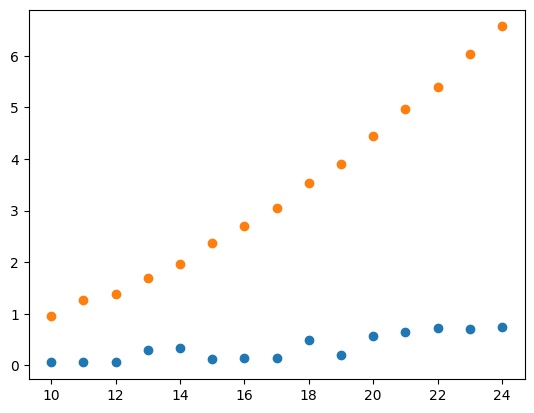

In [54]:
grid_sizes = list(range(10, 25))
scale_size = [run_backwards_experiment(g, 2) for g in tqdm.tqdm(grid_sizes)]
plt.scatter(grid_sizes, [t[0] for t in scale_size], label="Solve Time")
plt.scatter(grid_sizes, [t[1] for t in scale_size], label="Build Time")


In [55]:
print(run_backwards_experiment(40, 2))

(4.124002792173997, 21.872854874935)


In [56]:
print(run_backwards_experiment(50, 2))

(5.35139966593124, 32.54321137513034)


In [57]:
start = timer()
grid_size = 50
indices_2 = [[[] for j in range(grid_size)] for i in range(grid_size)]
indices_3 = [[[] for j in range(grid_size)] for i in range(grid_size)]
for i, j in itertools.product(range(grid_size), range(grid_size)):
    neighbors = []
    for di, dj in itertools.product(range(-1, 2), range(-1, 2)):
        if di == dj == 0:
            continue
        if 0 <= i + di < grid_size and 0 <= j + dj < grid_size:
            neighbors.append((i + di, j + dj))
    for comb, comp in comb_and_comp(neighbors, 2):
        indices_2[i][j].append((comb, comp))
    for comb, comp in comb_and_comp(neighbors, 3):
        indices_3[i][j].append((comb, comp))
end = timer()
print(f"{end - start:.5f}")

0.57009
